# **Statistics lecture 3 Hands-on session : solutions notebook**

This is the companion notebook to lecture 3 in the statistical course series, covering the following topics:
1. Neyman-Pearson lemma
2. Testing for discovery, using simple tools
3. Discovery as a hypothesis test
4. Testing for discovery in a histogram

First perform the usual imports:

In [2]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

## 1.  Neyman-Pearson lemma

In the previous lecture, we have applied hypothesis testing to a simple counting experiment, using the observed count $n$ as discriminant.
Recall:

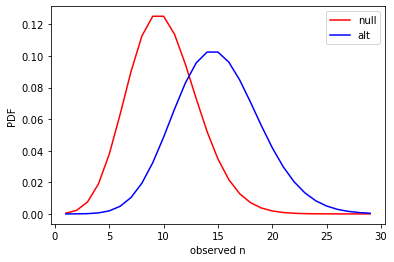

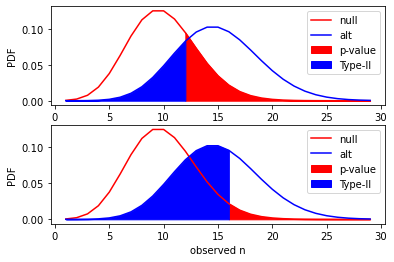

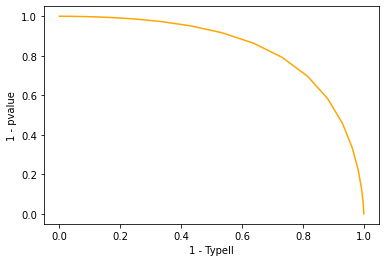

In [3]:
b = 10 # background of 10 events
s_null = 0 # the null hypothesis: no signal
s_alt  = 5 # the alternate hypothesis: 

ns = np.arange(1, 30, 1) # consider various observed values

# Compute the PDF values for the different n
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();

# A couple of plots illustrating different test sizes
plt.figure()
plt.subplot(211)
threshold1 = 12
lo1 = np.arange( 1, threshold1 + 1, 1)
hi1 = np.arange(threshold1, 30, 1)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.fill_between(hi1, scipy.stats.poisson.pmf(hi1, s_null + b), color='r', label='p-value')
plt.fill_between(lo1, scipy.stats.poisson.pmf(lo1, s_alt  + b), color='b', label='Type-II')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();
#
plt.subplot(212)
threshold2 = 16
lo2 = np.arange( 1, threshold2 + 1, 1)
hi2 = np.arange(threshold2, 30, 1)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.fill_between(hi2, scipy.stats.poisson.pmf(hi2, s_null + b), color='r', label='p-value')
plt.fill_between(lo2, scipy.stats.poisson.pmf(lo2, s_alt  + b), color='b', label='Type-II')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();

# Now draw the ROC curve
thresholds = np.arange(1, 30, 1)
plt.figure()
plt.plot(scipy.stats.poisson.sf(thresholds, s_alt + b), scipy.stats.poisson.cdf(thresholds, s_null + b), color='orange')
plt.xlabel('1 - TypeII');
plt.ylabel('1 - pvalue');

This is however a special situation, in which the entire measurement information is already contained in the single number $n$ -- so we didn't need to worry about how to define our discriminant, we could just use $n$.

In general this is not the case, and the observed dataset consists of several quantities. We then need to condense the information into a single value, which nevertheless contains the maximal amount of information.

We investigate this in the context of a binned analysis, studied already in the previous lecture:

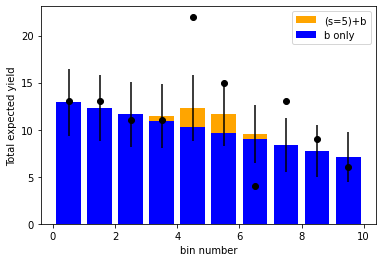

In [4]:
# Define the binning
nbins = 10
x = np.linspace(0.5, nbins - 0.5, nbins)

# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_fracs = b_yields/np.sum(b_yields)

# The signal shape is a peak
s_fracs = np.zeros(nbins)
s_fracs[3:7] = [ 0.1, 0.4, 0.4, 0.1 ]


# Define the signal and background
s = 5
b = 100
s_and_b = s*s_fracs + b*b_fracs
b_only = b*b_fracs

# Now generate some data
np.random.seed(0) # make sure we always generate the same
data = [ np.random.poisson(s*s_frac + b*b_frac) for s_frac, b_frac in zip(s_fracs, b_fracs) ]
plt.bar(x, s_and_b, color='orange', yerr=np.sqrt(s_and_b), label='(s=5)+b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

We want to test $s = 0$ against $s = 5$. First, we try our previous technique: pick one bin, and perform the test in this bin only:

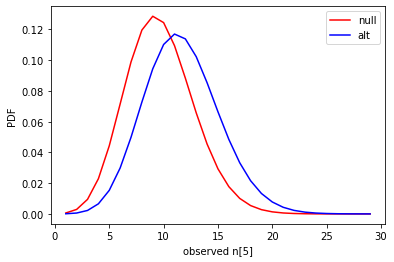

In [5]:
# Define the hypotheses
s_null = 0 # the null hypothesis: no signal
s_alt  = 5 # the alternate hypothesis: 

# We test the content of bin 5
i_bin = 5  # test bin 5

# Scan over the values of b
ns = np.arange(1, 30, 1)

# Compute and plot the PDF values for the different n
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null*s_fracs[i_bin] + b*b_fracs[i_bin]), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt*s_fracs[i_bin] + b*b_fracs[i_bin]), color='b', label='alt')
plt.xlabel('observed n[%d]' % i_bin)
plt.ylabel('PDF')
plt.legend();

One can already see that this is not a very good test: the distributions are stongly overlapping, and the hypotheses are therefore hard to separate. Let's draw the ROC curve:

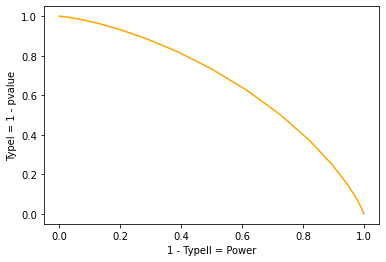

In [6]:
# Define the threshold values to consider
n_thresholds = np.arange(0, 30, 1)

# Compute the results
null_cdf = [ scipy.stats.poisson.cdf(n_threshold, s_null*s_fracs[i_bin] + b*b_fracs[i_bin]) for n_threshold in n_thresholds ]
alt_sf   = [ scipy.stats.poisson.sf (n_threshold,  s_alt*s_fracs[i_bin] + b*b_fracs[i_bin]) for n_threshold in n_thresholds ]

# Plot the results
plt.plot(alt_sf, null_cdf, color='orange')
plt.xlabel('1 - TypeII = Power');
plt.ylabel('TypeI = 1 - pvalue');

The curve looks perilously close to the diagonal, which corresponds to no sensitivity.

Now let's see if we can do better using the Neyman-Pearson theorem. It states that to separate $s_{\text{null}}$ from $s_{\text{alt}}$, the optimal discriminant is $L(s_{\text{null}})/L(s_{\text{alt}})$. We may as well take $-2\log$ of this as usual, so that our discriminant is
$$
t(s_{\text{null}}, s_{\text{alt}}) = -2 \log \frac{L(s_{\text{null}})}{L(s_{\text{alt}})}.
$$

Let's repeat our sensitivity studies with this new discriminant. First let's implement the discriminant:

In [7]:
def lambda_s(s_hypo, data) :
    return -2*sum( [ np.log(scipy.stats.poisson.pmf(n, s_hypo*s_frac + b*b_frac)) for n, s_frac, b_frac in zip(data, s_fracs, b_fracs) ] )


def t_s(data) :
    return lambda_s(s_null, data) - lambda_s(s_alt, data)

We can't plot the distributions of $t$ outright, since we don't know what distribution it follows (for the case of $n$, we knew from first principles that it followed a Poisson, but we don't have something similar here).

So we'll simply generate these distributions by sampling: we will draw a large number of random datasets for $s = s_{\text{null}}$, make a histogram of the values of $t$, and this will provide an approximation of its distribution for $s = s_{\text{null}}$. We can then repeat for $s = s_{\text{alt}}$ to make our plot.

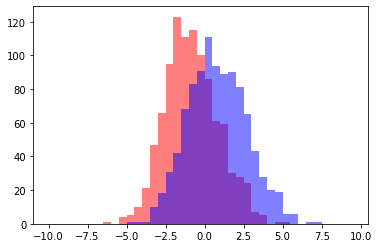

In [8]:
# Generate 1000 random datasets for each distribution (more is better, but takes longer)
ndata = 1000

# Function to generate the dataset and compute the values of t
def generate_t_values(s_hypo, ndata = 1000) :
  t_values = []
  for k in range(0, ndata) :
    data = [ np.random.poisson(s_hypo*s_frac + b*b_frac) for s_frac, b_frac in zip(s_fracs, b_fracs) ]
    t_values.append(t_s(data))
  return t_values

hist_null = generate_t_values(s_null, ndata)
hist_alt  = generate_t_values(s_alt , ndata)
plt.hist(hist_null, color='red', alpha=0.5, bins=np.arange(-10,10,0.5));
plt.hist(hist_alt, color='blue', alpha=0.5, bins=np.arange(-10,10,0.5));

The separation between the curves looks slightly better than in the previous case. We can check this by computing the ROC curve, scanning over different threshold values on the discriminant t.

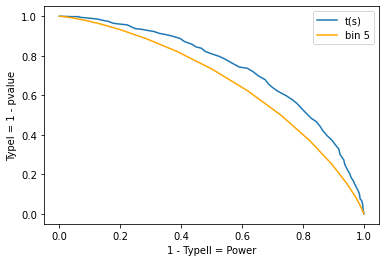

In [9]:
# Threshold values
t_thresholds = np.arange(-10, 10, 0.1)

# Compute the p-value and power for each threshold
cdf_null = np.searchsorted(np.sort(hist_null), t_thresholds)/ndata
sf_alt = 1 - np.searchsorted(np.sort(hist_alt), t_thresholds)/ndata

# Plot the result
plt.plot(sf_alt, cdf_null, label='t(s)')
plt.plot(scipy.stats.poisson.sf(n_thresholds, s_alt*s_fracs[i_bin] + b*b_fracs[i_bin]), scipy.stats.poisson.cdf(n_thresholds, s_null*s_fracs[i_bin] + b*b_fracs[i_bin]), color='orange', label='bin 5')
plt.xlabel('1 - TypeII = Power')
plt.ylabel('TypeI = 1 - pvalue')
plt.legend();

The upshot of all this is that the likelihood ratio (LR) prescribed by the Neyman-Pearson lemma indeed seems better than bin 5 alone. This is not surprising, given that the LR combines information from all the bins, and assigns more weight to bins with more signal. We won't check it here, but the LR is optimal is the sense that no other combination of the per-bin measurements provides better performance.

In the following, we will use the LR systematically when performing tests. We will also drop Type-II errors from the discussion, and focus only on the p-value (Type-I error rate). Since the LR is optimal anyway, we can do this and trust that the Type-II error rate is as low as it can be.

## 2. Testing for discovery, using simple tools

First test we consider is *discovery* testing, i.e. testing for the presence of a signal. As an illustration, we can go back to a binned example:

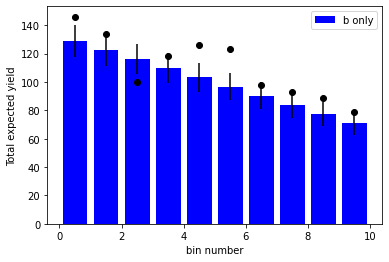

In [10]:
# Define an example with more signal, to make it interesting
s = 70
b = 1000
s_and_b = s*s_fracs + b*b_fracs
b_only = b*b_fracs

# Generate a dataset
np.random.seed(6) # make sure we always generate the same
data = [ np.random.poisson(s*s_frac + b*b_frac) for s_frac, b_frac in zip(s_fracs, b_fracs) ]

# Plot the results
plt.bar(x, b_only, yerr=np.sqrt(b_only), color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

Only the background is plotted, but we can ask whether there is a signal present as well (seems so!). How do we test for this ?

To simplify matters, let's focus first on a single bin, say bin 4. The event counts are as follows:

In [13]:
b4 = b*b_fracs[4]
n4 = data[4]
print('n[4] =', n4, ', b[4] =', b4)

n[4] = 126 , b[4] = 103.2258064516129


This implies that there is an amount of signal present that can be estimated as

In [14]:
s4 = n4 - b4
print(s4)

22.774193548387103


This seems sizable, but it could well be due to a random fluctuation of the background. How do we tell ? We know that the typical size of the fluctuations is the RMS of the background yield, which is given by its square root:

In [15]:
sigma4 = np.sqrt(b4)
z4 = s4/sigma4
print('sigma4=', sigma4, 'z =', z4)

sigma4= 10.16001016001524 z = 2.241552241553363


So the observed signal is between 2 and 3 times the RMS : a bit larger than the typical fluctuation, but not huge either. How do we quantify how often such a fluctuation would happen ? Do do this, we can assume that the background count is distributed as Gaussian, with central value $b_4$ and width $\sqrt{b_4}$. How likely are we to see a fluctuation as large as the signal ?

For this, we just need to reuse the Gaussian quantiles studied in the first lecture:

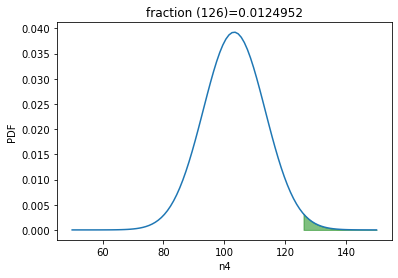

In [16]:
plot_b = np.linspace(50,150,100)
plt.plot(plot_b, scipy.stats.norm.pdf(plot_b, b4, sigma4))
plt.xlabel('n4')
plt.ylabel('PDF')

# Now fill in part of the distribution and print the integral
shaded_b = np.linspace(n4, 150, 100)
plt.fill_between(shaded_b, scipy.stats.norm.pdf(shaded_b, b4, sigma4), alpha=0.5, color='g');
plt.title('fraction (%g)=%g' % (n4, scipy.stats.norm.sf(n4, b4, sigma4)));

So a fluctuation at least as large as the signal should happen in only $1\%$ of cases. This is already a pretty good numerical indication that this is not a typical situation, but not completely exceptional either.

Recalling the previous section, one can see that this number is a p-value, the rate for a Type-I error. The null hypothesis corresponds to $s=0$, and this is the signal value for which we have drawn the PDF above. The shaded area corresponds to the fraction of cases above the observation, which we want to use as a threshold to reject the hypothesis. The integral above this threshold measures how often this happens if the hypothesis is true, which is the p-value.

As usual, small p-values mean good exclusion, and point towards discovery, while large p-values (close to 1) point to good agreement with the null. 
We need to set a threshold on the p-value, below which we feel it is safe to exclude $s=0$.

How small is small enough ? This is usually expressed in terms of significance, not p-value. The mapping is as follows:

In [14]:
bounds = [0, 1, 2, 3, 4, 5]
one_sided_tail = [ scipy.stats.norm.sf(up) for up in bounds ]

# Pretty-print the result
import pandas as pd
import jinja2
fields = np.array([ bounds, one_sided_tail ]).T
labels = [ 'Number of standard deviations from the mean', '1-sided tail fraction' ]
pd.DataFrame(fields, columns=labels)

,Number of standard deviations from the mean,1-sided tail fraction
0,0.0,5.000000e-01
1,1.0,1.586553e-01
2,2.0,2.275013e-02
3,3.0,1.349898e-03
4,4.0,3.167124e-05
5,5.0,2.866516e-07


These numbers are valid for any Gaussian, with the number of standard deviations defined as
$$
z = \frac{x - x_0}{\sigma}
$$
So we can express our p-value as a number of standard deviations. In fact this is what we computed before:
$$
z = \frac{n_4 - b_4}{\sqrt{b_4}} = \frac{s_4}{\sqrt{b_4}}.
$$

So this is the expression for the significance in the Gaussian case. It is completely equivalent to the p-value: one can go from one to the other using the table above. Significances are however easier to understand, and also usually easier to compute. In our case, as computed above, we have:

In [15]:
z4 = s4/np.sqrt(b4)
print('z = ', z4)

z =  2.241552241553363


and one can go from this to the p-value using the normal 1-CDF function:

In [16]:
p4 = scipy.stats.norm.sf(z4)
print(p4)

0.012495162778418261


Which is again a value we obtained above.

Historically, thresholds for discoveries in physics have been defined in terms of the significance as follows:
* $z \ge 5$ : "real" discovery
* $z \ge 3$ : "evidence" for a signal -- suggestive but not quite at the threshold for a discovery
So in this context, our excess above is not significant as it doesn't even meet the $3\sigma$ threshold. To reach a $5\sigma$ discovery, we would have needed

In [17]:
print('s4 for discovery = ', 5*np.sqrt(b4))

s4 for discovery =  50.8000508000762


## 3. Discovery testing as a hypothesis test

Earlier in the lecture, we described statistics tests in terms of
* Definition of hypotheses (null and alternate)
* Definition of the discriminant
* Rate of Type-I errors (false positives), a.k.a. p-value and Type-II errors (false negatives)

The discovery setup we have just explored can be seen as exactly such a test. The parameters are as follows:
* Null: no signal; Alternate: any positive signal
* Discriminant: the likelihood ratio -- or in simple cases the measured yield.
* p-value: the tail integral seen above (false positive: probability to get an outcome that is larger than the threshold, even though the null is true)

We need to add one more element though: since the alternate can be *any* positive signal, how do we decide what value to use ? The natural solution is to use the best-fit value $\hat{s}$, so that the discriminant is finally
$$
t_0 = -2 \log \frac{L(s=0)}{L(\hat{s})}.
$$
the numerator is for the null, and uses $s=0$. The denominator uses $\hat{s}$ for the alternate.

First, let's check that this gives the same result as our previous determination, for a single bin counting. Recall that this is all for a Gaussian likelihood:
$$
L(s) = \exp\left[-\frac{1}{2} \left(\frac{(n - (s+b)}{\sqrt{s+b}}\right)^2 \right]
$$
First, what is the best-fit value $\hat{s}$ for a given $n$, the value that maximizes $L$ ? 

We need the exponent of the Gaussian to be zero, so $n = \hat{s} + b$  and $\hat{s} = n - b$.

So what is the value of $t_0$ ? From a simple computation,

$$
t_0 = \left(\frac{n - b}{\sqrt{b}}\right)^2 = \left(\frac{\hat{s}}{\sqrt{b}}\right)^2
$$

So it is equal to the square of the significance! In other words, once we have $t_0$, we can get the significance as
$$
z = \sqrt{t_0}
$$
and the p-value as

In [18]:
t0 = z4**2
scipy.stats.norm.sf(np.sqrt(t0))

0.012495162778418261

Of course this all is a bit overkill here, since we already had the answer using simpler methods. But now that we validated the technique on a simple example, we can apply it to a less trivial one, in the next section.

## 4. Testing for discovery in a histogram

Now that we have a general technique, let's apply all this to the full binned distribution above:

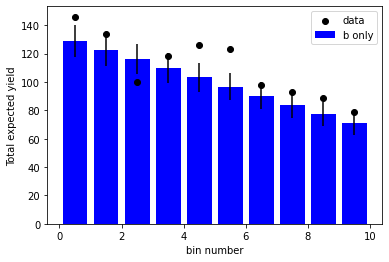

In [19]:
plt.bar(x, b_only, yerr=np.sqrt(b_only), color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

exact hat{s}: 62.62713906897173
t0 = 12.37329885777288 z = 3.517570021729899 p-value = 0.0002177587148763835


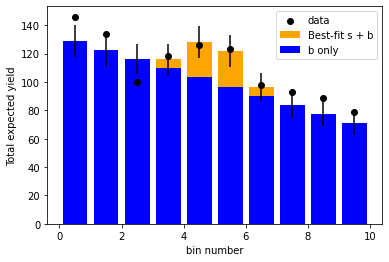

In [20]:
# Compute and print s_hat
# A slight technical issue is that we need to minimize lambda_s, which we've defined as a function of both s and data
# in order to get a function of s only, we build a small function on-the-fly using the 'lambda' operator of python
# (no relation to the likelihood ratio!)
from scipy.optimize import minimize_scalar
s_hat = minimize_scalar(lambda s: lambda_s(s, data), (0, 200)).x
print('exact hat{s}:', s_hat)

# Compute and print t0, z, and the p-value
t0 = lambda_s(0, data) - lambda_s(s_hat, data)
print('t0 =', t0, 'z =', np.sqrt(t0), 'p-value =', scipy.stats.norm.sf(np.sqrt(t0)))

# Compute the s_hat+b shape and plot the result
hats_plus_b = s_hat*s_fracs + b_only
plt.bar(x, hats_plus_b, yerr=np.sqrt(hats_plus_b), color='orange', label='Best-fit s + b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

So the results are much better when looking at all the bins, rather than just bin 4 : overall we have a $>3\sigma$ result, which is evidence for the signal.